<a href="https://colab.research.google.com/github/MaryamNourii/Form-OCR/blob/preprocess/FormOCR_Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils
import csv
import shutil

In [22]:
class preprocess():
  def __init__(self, path):
    self.path = path
    self.height = 700 
    self.width = 900 

  def preprocessing(self):
    self.img = self.read_image(self.path)
    self.roi = self.get_ROI(self.img)
    self.enhnc_roi = self.enhance_ROI(self.roi)
    self.get_words(self.enhnc_roi)

  def read_image(self,path):
    img = cv2.imread(path)
 
    img = cv2.resize(img, (self.width, self.height))
    # cv2_imshow(img)
    return img

  def get_ROI(self,img):
    img_copy=img.copy()
    gray_img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    # cv2_imshow(gray_img)
    edge_img = cv2.Canny(gray_img, 50, 200)
    # cv2_imshow(edge_img)
    contours, _ = cv2.findContours(edge_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)
    rects_cnt=[]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            x,y,w,h = cv2.boundingRect(approx)
            if (abs(w - self.width) < 20 and abs(h - self.height) < 20) or ( (w < 100) and (h < 110)) : continue 
            for r in rects_cnt:
              if (((x > r[0]-5 and x < r[0]+5) and (y > r[1]-5 and y < r[1]+5)) or abs((y + h) - (r[1] + r[3])) < abs(y - r[1])-2) :
                  x = r[0]
                  y = r[1]
                  w = r[2]
                  h = r[3]
            if ([x,y,w,h] not in rects_cnt) : 
              rects_cnt.append([x,y,w,h])
              cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0, 0, 255),2)
              # cv2_imshow(img_copy)

    roi = []
    count = 0
    for rect in rects_cnt:
      x = rect[0]+2
      y = rect[1]+2
      w = rect[2]-2
      h = rect[3]-2
      img_slice = img[y:y+h, x:x+w]
      roi.append(img_slice)
      cv2_imshow(img_slice)

    return roi    
    
  def enhance_ROI(self, roi):
    count = 0
    e_ROI = [] 
    for image in roi:
      h = image.shape[0] * 4
      w = image.shape[1] * 4
      image = cv2.resize(image, (w, h))                                                                                                                                                                                                                                                                                                                          

      mask = np.zeros(image.shape, dtype=np.uint8)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
      cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      cnts = cnts[0] if len(cnts) == 2 else cnts[1]
      for c in cnts:
          area = cv2.contourArea(c)
          if area < 10000:
              cv2.drawContours(mask, [c], -1, (255,255,255), -1)

      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      # cv2_imshow(mask)
      result = cv2.bitwise_and(image,image,mask=mask)
      # cv2_imshow(result)
      result[mask==0] = (255,255,255)


      height =int(result.shape[0] / 4)
      width =int(result.shape[1] / 4)
      result = cv2.resize(result, (width, height))
      # cv2_imshow(result)
      e_ROI.append(result)
      cv2.imwrite('/content/imgs/' + str(count)  + '.png', result)
      count += 1
    return e_ROI

  def get_words(self, enhnc_roi):
      img_count = 0
      words = {}
      word_count = 0
      pos = []
      for image in enhnc_roi:
        # h = image.shape[0] * 2
        # w = image.shape[1] * 2
        # image = cv2.resize(image, (w, h)                                                                                                                                                                                                                                                                                                                          )
        img1 = image.copy()
        # pos = []
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.blur(gray, (12, 12))
        thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        # cv2_imshow(thresh)
        cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            x, y, w, h = cv2.boundingRect(c)
            if (x == 0):  x+=5
            if (y == 0):  y+=5
            if ([x,y,w,h] not in pos and w > 0 and h > 0) : 
              cv2.rectangle(image, (x-5, y-5), (x+w+5, y+h+5), (0, 255, 0), 2)
              word = img1[y-5:y+h+5, x-5:x+w+5]
              word_pos=[img_count,x, y, w, h]
              pos.append([x, y, w, h])
              words[word_count]={'img' : word,'pos':word_pos}
              word_count += 1
        cv2_imshow(image)
        img_count +=1
      
        count=0
        header = ['name', 'img', 'x', 'y', 'w', 'h']
        with open('/content/words/words.csv', 'w') as file:
            writer = csv.writer(file)
            writer.writerow(header)
            for i in words:
              # print([str(count), str(words[i]['pos'][0]), str(words[i]['pos'][1]), str(words[i]['pos'][2]) ,  str(words[i]['pos'][3]) , str(words[i]['pos'][4])])
              writer.writerow([str(count),str(words[i]['pos'][0]), str(words[i]['pos'][1]), str(words[i]['pos'][2]) ,  str(words[i]['pos'][3]) , str(words[i]['pos'][4])])

              hgh = int(2 * words[i]['img'].shape[0])
              wdth = int(2 * words[i]['img'].shape[1])
              if hgh > 0 and wdth > 0:
                img = cv2.resize(words[i]['img'],(wdth,hgh),interpolation=cv2.INTER_CUBIC)
                image_extended = cv2.copyMakeBorder(src=img, top=10, bottom=10, left=70, right=70, borderType=cv2.BORDER_REPLICATE)               
              
                cv2.imwrite('/content/words/' + str(count)  + '.png', image_extended)
                count += 1


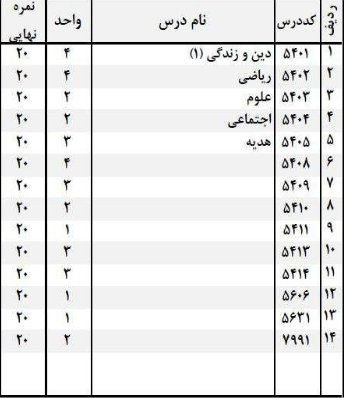

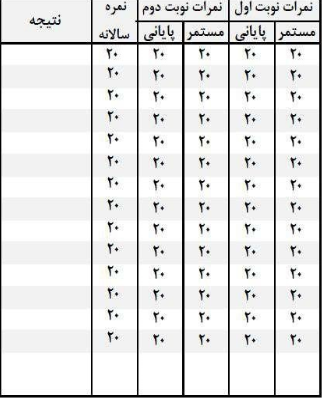

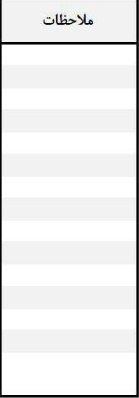

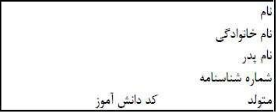

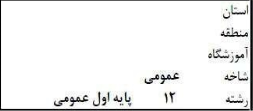

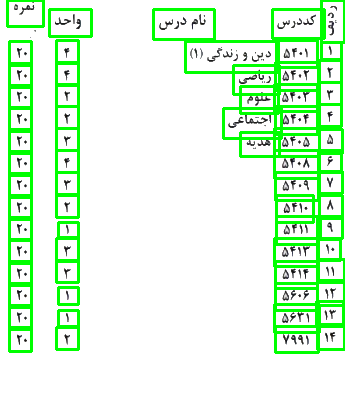

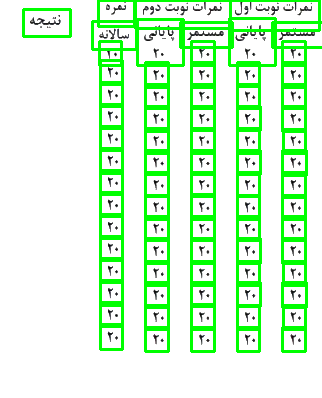

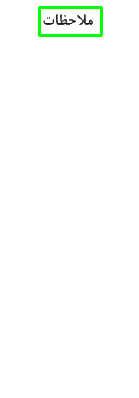

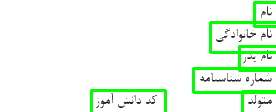

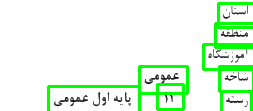

In [23]:
pr = preprocess('Form_1.jpg')
pr.preprocessing()

In [24]:
shutil.make_archive('/content/words', 'zip', '/content/words')

'/content/words.zip'